***Para esta avaliação, você deve entregar três arquivos:***

<p>-- um arquivo de dados em .csv com a base resultante das análises.
<p>-- um relatório em .ipynb com suas análises comentadas</p>
<p>-- um arquivo .pdf gerado a partir do .ipynb</p>
_______________________________________________________________________________

In [1]:
#Importando as libs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pylab import rcParams
from pmdarima import auto_arima     
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error,mean_absolute_error


from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(rc={'figure.figsize':(16,6)})

# <span style="color:red"> ***Exercício 1:***  </span> Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os dados estão corretos e realizar algum procedimento necessário caso haja dados faltantes.

In [3]:
# Fazendo a leitura dos dados e colocando a data como index. Acabei renomeando as colunas também
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True).rename({'confirmed': 'Confirmados', 'deaths': 'Mortes'}, axis='columns')
covid

,Confirmados,Mortes
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0
...,...,...
2020-08-30,44143,1006
2020-08-31,35581,290
2020-09-01,33850,529


In [4]:
#Fazendo uma descritiva básica
covid.describe()

,Confirmados,Mortes
count,247.000000,247.000000
mean,24754.680162,752.000000
std,21935.393529,768.724934
min,0.000000,0.000000
25%,19.500000,1.000000
50%,23705.000000,661.000000
75%,41252.500000,1180.500000
max,78427.000000,4928.000000


In [5]:
#Avaliando se temos alguma variável com missing
pd.DataFrame(covid.isna().sum()).rename(columns={0: "Quantidade_De_Missings"}).sort_values(by=['Quantidade_De_Missings'],ascending=False)

,Quantidade_De_Missings
Confirmados,0
Mortes,0


In [6]:
# Avaiando acima, pode-se perceber que não existem dados missing

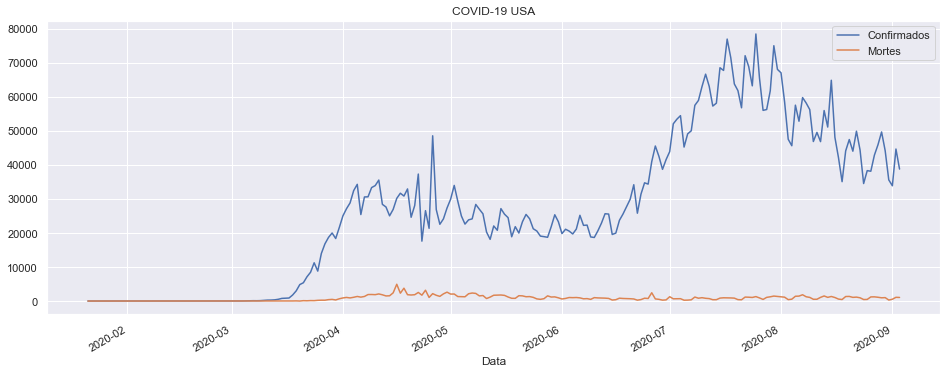

In [7]:
# Avaliando os casos ao longo do tempo graficamente
title = 'COVID-19 USA'
ylabel = ''
xlabel = 'Data'

ax=covid[covid['Confirmados']>0].plot(title=title);
ax.autoscale(axis='both');
ax.set(xlabel=xlabel,ylabel=ylabel);

ax.xaxis.grid(True) 
ax.yaxis.grid(True)

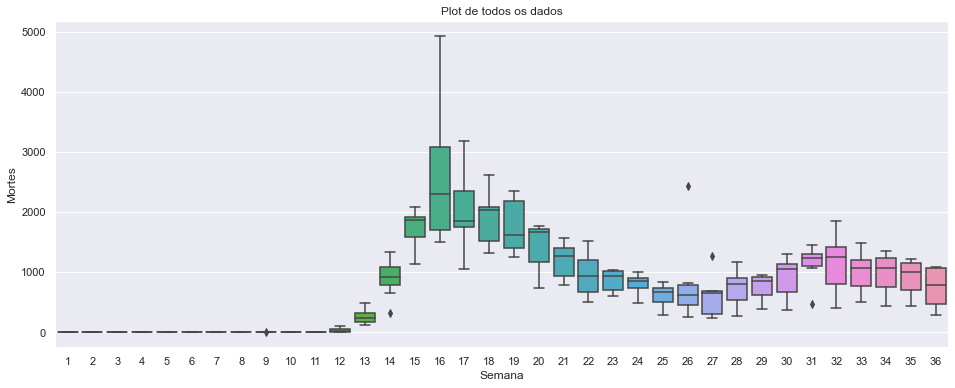

In [8]:
covid['Semana'] = covid.index.week
# Avaliando via box plot das semanas, a quantidade de mortes. Utilizando isso como ferramenta auxiliar para identificar 
# eventuais problemas nos dados
sns.boxplot(x=covid['Semana'], y=covid['Mortes']).set_title("Plot de todos os dados");

In [9]:
covid[covid['Semana']==26]

,Confirmados,Mortes,Semana
date,,,
2020-06-22,25793,256,26
2020-06-23,31390,427,26
2020-06-24,34720,826,26
2020-06-25,34339,751,26
2020-06-26,40949,2437,26
2020-06-27,45527,623,26
2020-06-28,42486,500,26


***Avaliando o incremento de mortes reportadas, parece que trata-se de um lancamento de mortes represadas, como em alguns casos 
já aconteceram no brasil. Para avaliar com maior exatidão, uma das alternativas seria avaliar com os especialistas na área
se este número é realmente real ou trata-se de uma anomalia. No caso de uma anomalia, poderíamos tratá-la como realmente um 
outlier fazendo os ajustes necessários. Buscando no google brevemente, não encontrei motivos fortes para descartar estes dados 
realizar algum tipo de tratamento. Dessa forma, as análises terão continuidade considerando estes pontos como parte dos dados***


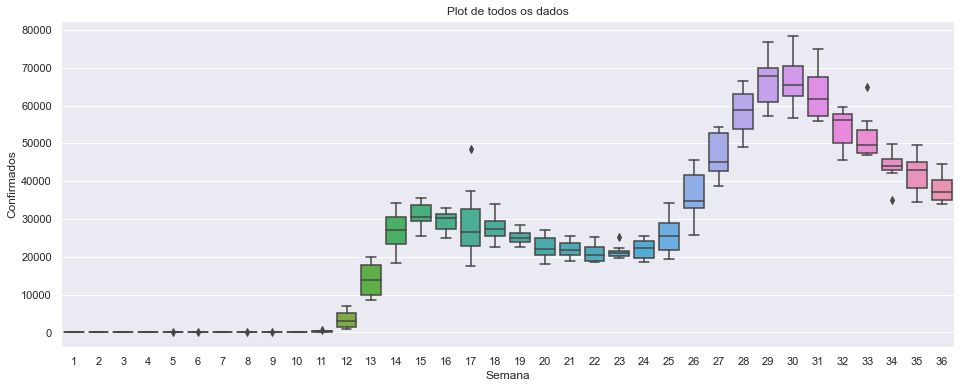

In [10]:
sns.boxplot(x=covid['Semana'], y=covid['Confirmados']).set_title("Plot de todos os dados");

***Avaliando o gráfico acima, seguindo a mesma lógica do anterior, nenhum tratamento será realizado***

In [11]:
#Iniciando tratamento para garantir que nao temos "buracos" nas datas
print('Minimo:',covid.index.min())
print('Máximo:',covid.index.max())

Minimo: 2020-01-01 00:00:00
Máximo: 2020-09-03 00:00:00


In [12]:
idx = pd.date_range(start='2020-01-01', end='2020-09-03', freq='D')
idx

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', length=247, freq='D')

In [13]:
covid = covid.reindex(idx)

***O tratamento acima visa não deixar "buracos" entre as datas, uma vez que podemos ter dados observados por exemplo no dia 01/01/2020 e depois somente no dia 04/01/2020. Ao realizá-lo, no caso de termos criado novas datas, os dados de mortes e casos resultariam em NaN values e seria necessário fazer algum tratamento. Abaixo, verificamos se isso ocorreu:***

In [14]:
#Avaliando se temos alguma variável com missing
pd.DataFrame(covid.isna().sum()).rename(columns={0: "Quantidade_De_Missings"}).sort_values(by=['Quantidade_De_Missings'],ascending=False)

,Quantidade_De_Missings
Confirmados,0
Mortes,0
Semana,0


***Como observado acima, não existem buracos entre as datas, sendo desnecessário este tipo de tratamento***

# <span style="color:red"> ***Exercício 2:***  </span>  Proponha uma decomposição dos dados de mortes em tendência e sazonalidade. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente brevemente os resultados.

***Avaliando o gráfico acima, parece existir certa sazonalidade nos dados. Para entender melhor, vou filtrar somente um período em que já possuimos mais massa de registros para dar um zoom no gráfico***

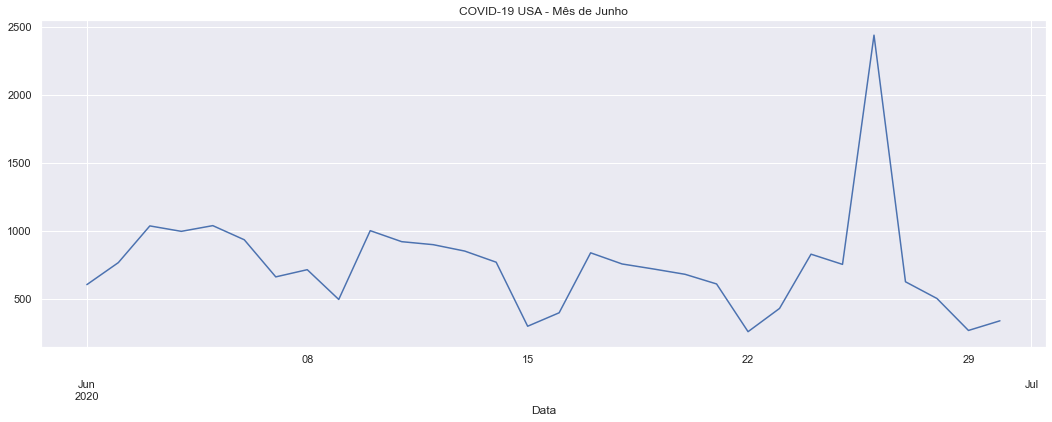

In [15]:
MesJunho=covid[covid.index.month == 6]
# Avaliando os casos ao longo do tempo graficamente
title = 'COVID-19 USA - Mês de Junho'
ylabel = ''
xlabel = 'Data'

ax=MesJunho[MesJunho['Mortes']>0]['Mortes'].plot(title=title,figsize=(18,6));
ax.autoscale(axis='both');
ax.set(xlabel=xlabel,ylabel=ylabel);

ax.xaxis.grid(True) # Com grades
ax.yaxis.grid(True)

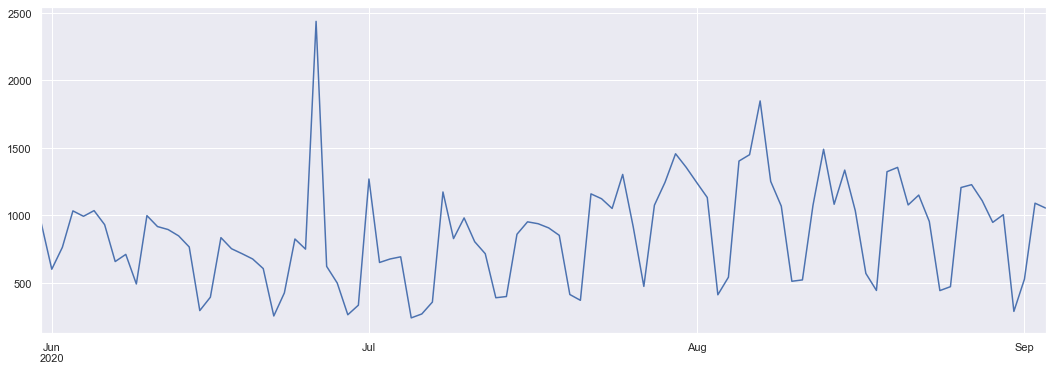

In [16]:
covid['Mortes']['2020-05-31':'2020-09-05'].plot(figsize=(18,6));

***Avaliando os gráficos acima, existe um indicativo que temos uma sazonalidade de 7 dias. Com isso, criarei para ter uma ideia visual médias móveis considerando 7 dias para realizar os plots.***

In [17]:
covid['MMSimples7_Mortes'] = covid['Mortes'].rolling(window=7).mean()
covid['MMExpPond7_Mortes'] = covid['Mortes'].ewm(span=7,adjust=False).mean()
covid['Semana'] = covid.index.week
covid.head(7)

,Confirmados,Mortes,Semana,MMSimples7_Mortes,MMExpPond7_Mortes
2020-01-01,0,0,1,NaN,0.0
2020-01-02,0,0,1,NaN,0.0
2020-01-03,0,0,1,NaN,0.0
2020-01-04,0,0,1,NaN,0.0
2020-01-05,0,0,1,NaN,0.0
2020-01-06,0,0,2,NaN,0.0
2020-01-07,0,0,2,0.0,0.0


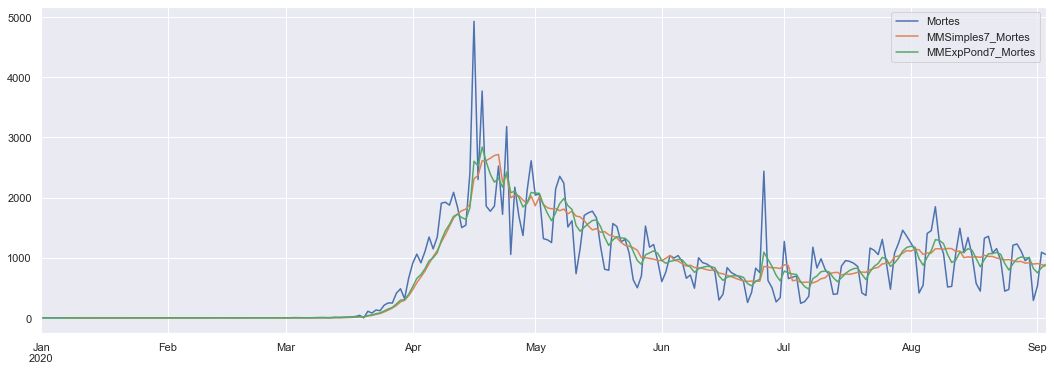

In [18]:
covid[['Mortes','MMSimples7_Mortes','MMExpPond7_Mortes']].plot(figsize=(18,6));

***Agora, iremos aplicar uma decomposição em tendência e sazonalidade do número de <span style="color:red">  mortes </span>. Visto que nos passos anteriores percebemos que existe aparentemente uma sazonalidade de 7 dias, aplicaremos o periodo igual a 7***



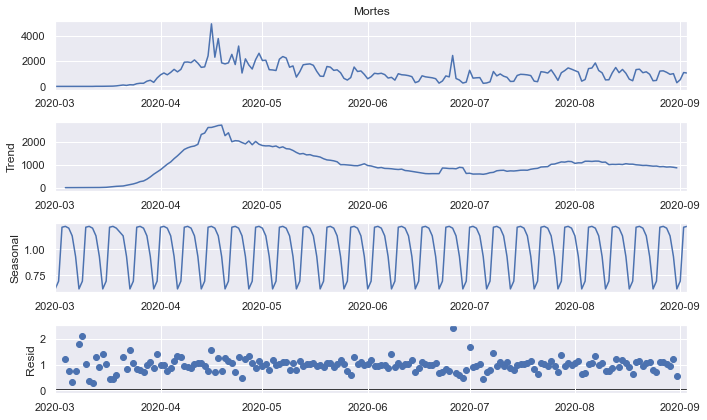

In [19]:
#Avaliando a sazonalidade multiplicativa
result = seasonal_decompose(covid[covid['Mortes']>0]['Mortes'], model='multiplicative', period=7)
rcParams['figure.figsize'] = 10, 6
fig = result.plot()
plt.show()

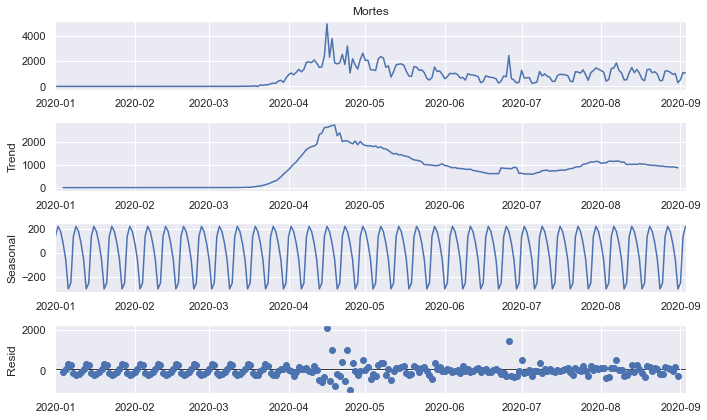

In [20]:
#Avaliando a sazonalidade Aditiva
result = seasonal_decompose(covid['Mortes'], model='additive', period=7)
rcParams['figure.figsize'] = 10, 6
fig = result.plot()
plt.show()

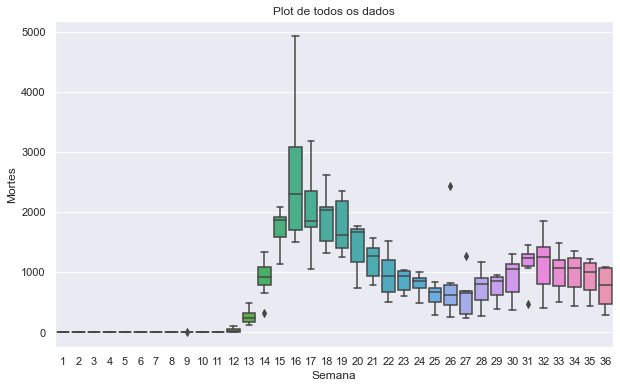

In [21]:
# Avaliando via box plot das semanas, a quantidade de mortes. Utilizando isso como ferramenta auxiliar para identificar 
# o tipo de sazonalidade
sns.boxplot(x=covid['Semana'], y=covid['Mortes']).set_title("Plot de todos os dados");

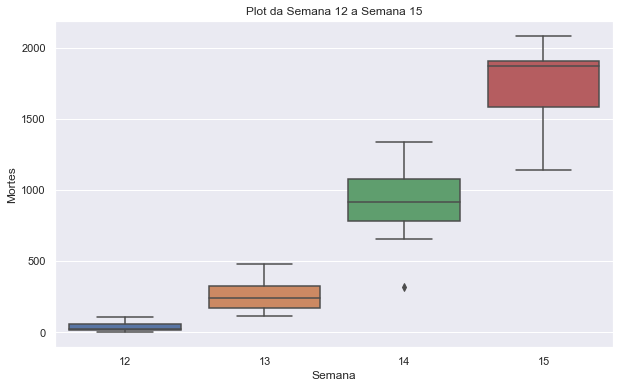

In [22]:
# Avaliando os gráficos de decomposição e os boxplot, me parece que a multiplicativa se adequa mais aos dados. Para avaliar 
# melhor, vou filtrar dois períodos observados no gráfico acima
# covid[covid['Semana']==15]
sns.boxplot(x=covid['Semana']['2020-03-16':'2020-04-12'], y=covid['Mortes']).set_title("Plot da Semana 12 a Semana 15");

***Avaliando os gráficos de decomposição acima, existe indicativo que devemos considerar sazonalidade é multiplicativa. Os boxplots criados acima auxiliam neste diagnóstico, visto que os tamanhos das caixas dos boxplots apresentam um incremento com o passar do tempo. Abaixo, avaliaremos outro período extraido:***

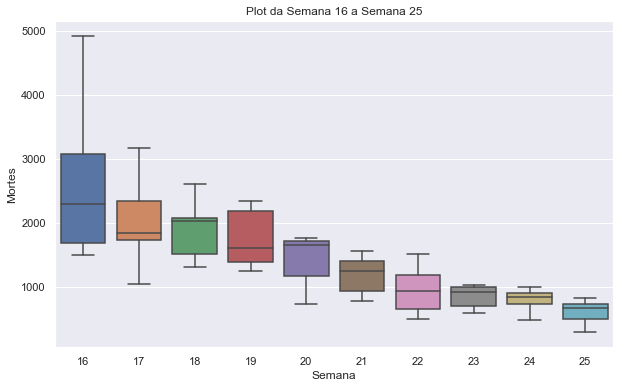

In [23]:
sns.boxplot(x=covid['Semana']['2020-04-13':'2020-06-21'], y=covid['Mortes']).set_title("Plot da Semana 16 a Semana 25");

***Avaliando o gráfico acima, percebemos que a medida que a quantidade de mortes cai, a amplitude do boxplot também é reduzida, mais um indício de possuirmos uma sazonalidade multiplicativa***

***Avaliando todas as análises gráficas acima, conclui-se que a <span style="color:red"> sazonalidade multiplicativa </span> é a mais adequada. Também avaliando a forma dos dados considerando o período completo, percebe-se que a tendência também não possui uma característica linear visto por exemplo incremento exponencial no início da pandemia. Dessa forma, temos também forte indicativo que devemos considerar tendencia multiplicativa***

***Agora, iremos avaliar os correlogramas***

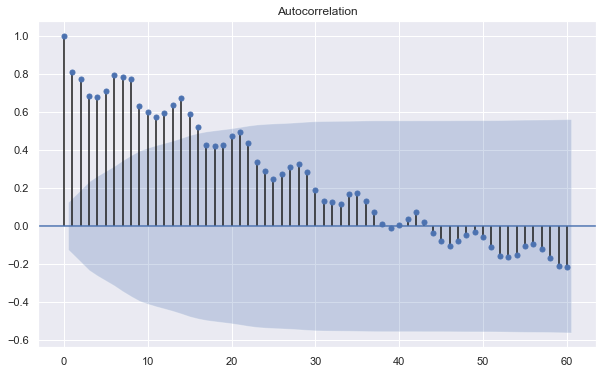

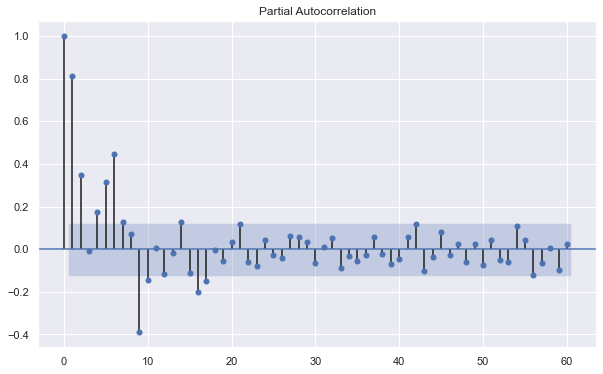

In [24]:
# Correlograma
plot_acf(covid['Mortes'], lags=60)
plot_pacf(covid['Mortes'], lags=60)
plt.show()

***Observando os gráficos acima, é possível perceber uma clara sazonalidade nos dados, com diversas correlações acima dos limites do intervalo, indicando possivelmente que deva ser considerado um componente AR e de Média Móvel. Para uma melhor diagnóstico, poderíamos usar um stepwise para identificar qual o melhor modelo, como pode ser observado no exmplo abaixo, em que é indicado um SARIMA(3,1,3)(2,0,1)[7]:***

In [25]:
# Ajuste de modelo SARIMA 
auto_arima(covid['Mortes'],seasonal=True,m=7).summary()
stepwise_fit = auto_arima(covid['Mortes'], start_p=0, start_q=0,
                          max_p=15, max_d=7, max_q=6, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3733.999, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3729.999, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3654.779, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3652.585, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3728.021, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3667.603, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3596.109, Time=0.60 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3638.860, Time=0.29 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3592.673, Time=0.97 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3603.517, Time=0.65 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3594.297, Time=1.07 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3594.062, Time=1.00 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3688.287, Time=0.53 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3587.379, Time=0.91 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

In [26]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  247
Model:             SARIMAX(3, 1, 3)x(2, 0, [1], 7)   Log Likelihood               -1774.976
Date:                             Tue, 15 Sep 2020   AIC                           3569.952
Time:                                     17:03:05   BIC                           3605.005
Sample:                                          0   HQIC                          3584.066
                                             - 247                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8308      0.066     12.631      0.000       0.702       0.960
ar.L2         -0.4738      0.082     -5.749      0.000      -0.635      -0.312
ar.L3         -0.3890      0.052     -7.533      0.000      -0.490      -0.288
ma.L1         -1.5841      0.073    -21.819      0.000      -1.726      -1.442
ma.L2          1.3341      0.104     12.773      0.000       1.129       1.539
ma.L3         -0.3665      0.067     -5.507      0.000      -0.497      -0.236
ar.S.L7        0.5733      0.304      1.884      0.060      -0.023       1.170
ar.S.L14       0.1689      0.096      1.756      0.079      -0.020       0.357
ma.S.L7       -0.5866      0.291     -2.014      0.044      -1.157      -0.016
sigma2      1.084e+05   3913.047     27.702      0.000    1.01e+05    1.16e+05
===================================================================================
Ljung-Box (Q):                       43.07   Jarque-Bera (JB):              7741.76
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):             515.55   Skew:                             2.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# <span style="color:red"> ***Exercício 3:***  </span>  

In [27]:
# Fazendo a leitura dos dados e colocando a data como index. Acabei renomeando as colunas também
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True,usecols = ['date','deaths']).rename({'deaths': 'Mortes'}, axis='columns')

***Dividindo a base em treino e teste, sendo que o teste representa as últimas 21 observações***

In [28]:
treino = covid.iloc[:covid.shape[0]-21] # Dados de treinamento 
teste = covid.iloc[covid.shape[0]-21:] # Dados de teste 

***Aplicando o método de <span style="color:red"> Holt </span>***

In [29]:
modelo =  ExponentialSmoothing(treino['Mortes'], trend='add');
ajustadoH = modelo.fit();
treino['Holt'] = ajustadoH.fittedvalues.shift(-1);
treino.tail(3)

,Mortes,Holt
date,,
2020-08-11,523,881.409007
2020-08-12,1076,946.768569
2020-08-13,1490,NaN


***Ajuste do modelo pelo Método de <span style="color:red"> Holt-Winters </span> com sazonalidade e tendencia <span style="color:red"> aditiva </span>***

In [30]:
modelo =  ExponentialSmoothing(treino['Mortes'],trend='add',seasonal='add',seasonal_periods=7);
ajustadoHWAdd = modelo.fit();
treino['HoltWintersAditivo'] = ajustadoHWAdd.fittedvalues;
treino.tail(3)

,Mortes,Holt,HoltWintersAditivo
date,,,
2020-08-11,523,881.409007,875.543110
2020-08-12,1076,946.768569,1357.781656
2020-08-13,1490,NaN,1283.442113


***Ajuste do modelo pelo Método de <span style="color:red"> Holt-Winters </span> <span style="color:blue"> com sazonalidade e tendência multiplicativa </span>***

In [31]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade MULTIPLICATIVA. Para utilizar multiplicativa, devemos filtrar 
# os casos em que as mortes são maiores que zero
modelo =  ExponentialSmoothing(treino[treino['Mortes']>0]['Mortes'],trend='mul',seasonal='mul',seasonal_periods=7);
ajustadoHWMult = modelo.fit();
treino['HoltWintersMultiplicativo'] = ajustadoHWMult.fittedvalues;
treino.tail()

,Mortes,Holt,HoltWintersAditivo,HoltWintersMultiplicativo
date,,,,
2020-08-09,1069,1263.486827,1161.837746,1013.941770
2020-08-10,513,1035.518205,796.299142,532.918211
2020-08-11,523,881.409007,875.543110,724.080699
2020-08-12,1076,946.768569,1357.781656,1404.953323
2020-08-13,1490,NaN,1283.442113,1212.399598


***Ajuste o modelo <span style="color:red"> SARIMA </span> pelo <span style="color:red"> STEPWISE </span>***

In [32]:
auto_arima(treino['Mortes'],seasonal=True,m=7).summary()
stepwise_fit = auto_arima(treino['Mortes'], start_p=0, start_q=0,
                          max_p=15, max_d=7, max_q=6, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3418.337, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3418.463, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3353.998, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3349.966, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3416.508, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3359.633, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3306.511, Time=0.66 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3340.881, Time=0.24 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3303.352, Time=0.78 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3311.891, Time=0.56 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3307.512, Time=1.06 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3304.675, Time=0.87 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3387.570, Time=0.51 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3299.612, Time=0.95 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  226
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1626.137
Date:                           Tue, 15 Sep 2020   AIC                           3270.273
Time:                                   17:05:27   BIC                           3301.018
Sample:                                        0   HQIC                          3282.682
                                           - 226                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3165      0.091    -14.424      0.000      -1.495      -1.138
ar.L2         -0.6792      0.085     -7.978      0.000      -0.846      -0.512
ar.L3         -0.3656      0.090     -4.051      0.000      -0.542      -0.189
ar.L4         -0.4866      0.071     -6.860      0.000      -0.626      -0.348
ar.L5         -0.4032      0.047     -8.639      0.000      -0.495      -0.312
ma.L1          0.6281      0.101      6.246      0.000       0.431       0.825
ar.S.L7        0.9227      0.069     13.442      0.000       0.788       1.057
ma.S.L7       -0.7126      0.095     -7.538      0.000      -0.898      -0.527
sigma2      1.139e+05   3774.332     30.175      0.000    1.06e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       31.79   Jarque-Bera (JB):              6199.66
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):           63934.13   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Pegando os valores preditos
modelo = SARIMAX(treino['Mortes'],order=(5,1,1),seasonal_order=(1,0,1,7))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Mortes   No. Observations:                  226
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1626.137
Date:                           Tue, 15 Sep 2020   AIC                           3270.273
Time:                                   17:05:28   BIC                           3301.018
Sample:                               01-01-2020   HQIC                          3282.682
                                    - 08-13-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3165      0.091    -14.424      0.000      -1.495      -1.138
ar.L2         -0.6792      0.085     -7.978      0.000      -0.846      -0.512
ar.L3         -0.3656      0.090     -4.051      0.000      -0.542      -0.189
ar.L4         -0.4866      0.071     -6.860      0.000      -0.626      -0.348
ar.L5         -0.4032      0.047     -8.639      0.000      -0.495      -0.312
ma.L1          0.6281      0.101      6.246      0.000       0.431       0.825
ar.S.L7        0.9227      0.069     13.442      0.000       0.788       1.057
ma.S.L7       -0.7126      0.095     -7.538      0.000      -0.898      -0.527
sigma2      1.139e+05   3774.332     30.175      0.000    1.06e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       31.79   Jarque-Bera (JB):              6199.66
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):           63934.13   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***O modelo obtido: Avaliando o resultado acima, percebe-se que foi obitido um modelo com <span style="color:red"> ARIMA </span> com componente não sazonal Autoregressiva igual a 5 <span style="color:red">(p=5)</span> , integrado de ordem 1 <span style="color:red">(d=1)</span> e de Média Móvel de ordem 1 <span style="color:red">(q=1)</span>, sendo que a componente <span style="color:red">sazonal é de ordem 7</span> com compentes Autoregressivas de ordem 1 <span style="color:red">(P=1)</span>, não integrado <span style="color:red">(D=0)</span> e Média Móvel de ordem 1 <span style="color:red">(Q=1)</span>***

In [34]:
# Obtain predicted values
inicio=len(treino)
fim=len(treino)+len(teste)-1
previsoes_sarima = resultado.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA(5,1,1)(1,0,1,7)')
previsoes_sarima.index = teste.index

In [35]:
for i in range(len(previsoes_sarima)):
    print(f"predicted={previsoes_sarima[i]:<11.10}, expected={teste['Mortes'][i]}")

predicted=1313.836247, expected=1083
predicted=1340.965161, expected=1336
predicted=968.3570855, expected=1035
predicted=648.477578 , expected=571
predicted=758.0167394, expected=445
predicted=1249.13084 , expected=1324
predicted=1273.79237 , expected=1356
predicted=1437.646543, expected=1078
predicted=1155.970959, expected=1151
predicted=1093.768149, expected=956
predicted=698.4647595, expected=444
predicted=837.4994221, expected=473
predicted=1223.38561 , expected=1207
predicted=1332.164793, expected=1228
predicted=1337.100232, expected=1110
predicted=1257.815775, expected=949
predicted=1047.944313, expected=1006
predicted=799.9882223, expected=290
predicted=848.5267383, expected=529
predicted=1257.076695, expected=1091
predicted=1301.182429, expected=1055


***Iniciando a construção do Modelo Dinâmico***

In [36]:
# Fazendo a leitura dos dados e colocando a data como index. Acabei renomeando as colunas também
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True,usecols = ['date','deaths']).rename({'deaths': 'Mortes'}, axis='columns')
treino = covid.iloc[:covid.shape[0]-21] # Dados de treinamento 
teste = covid.iloc[covid.shape[0]-21:] # Dados de teste 

# Padronizando os dados
scaler = MinMaxScaler()
scaler.fit(treino)
scaled_treino = scaler.transform(treino)
scaled_teste  = scaler.transform(teste)

In [37]:
# definindo o gerador
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_treino, scaled_treino, length=n_input, batch_size=1)

In [38]:
# Definindo o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Ajustando o modelo
model.fit_generator(generator,epochs=1500)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0128
Epoch 2/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 3/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 4/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0088
Epoch 5/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 6/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 7/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 8/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 9/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 10/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 11/1500
219/219 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 12/

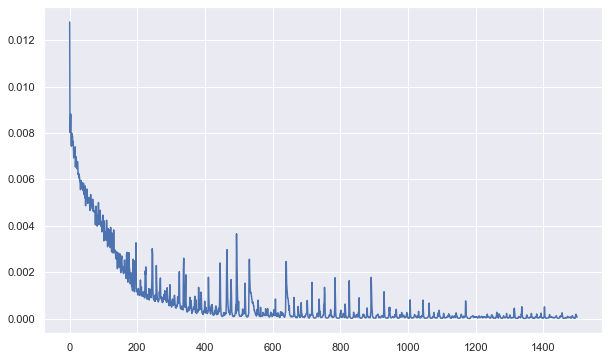

In [40]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [41]:
first_eval_batch = scaled_treino[-7:]

In [42]:
# Agora vamos considerar as previsões para as próximas observações e comparar com a base de teste
test_predictions = []

first_eval_batch = scaled_treino[-n_input:]
first_eval_batch

array([[0.375     ],
       [0.25405844],
       [0.2169237 ],
       [0.10409903],
       [0.10612825],
       [0.21834416],
       [0.3023539 ]])

In [43]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste
test_predictions = []

first_eval_batch = scaled_treino[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(teste)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
#como os dados foram padronizados, estamos voltando os mesmos na escala original
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
# true_predictions

***Aplicando os modelos avaliados na base de teste***

In [46]:
previsao_HWMul = ajustadoHWMult.forecast(21)
previsao_HWMul.index = pd.date_range(start='2020-08-14', end='2020-09-03', freq='D')
previsao_HWMul

2020-08-14    1446.308091
2020-08-15    1132.557499
2020-08-16     882.914207
2020-08-17     438.743028
2020-08-18     560.010575
2020-08-19    1182.965090
2020-08-20    1162.412430
2020-08-21    1307.871522
2020-08-22    1024.152260
2020-08-23     798.404126
2020-08-24     396.747771
2020-08-25     506.407928
2020-08-26    1069.734977
2020-08-27    1051.149560
2020-08-28    1182.685715
2020-08-29     926.123268
2020-08-30     721.983115
2020-08-31     358.772183
2020-09-01     457.935976
2020-09-02     967.342934
2020-09-03     950.536462
Freq: D, dtype: float64

In [47]:
# realizando as predições
teste['Holt'] = ajustadoH.forecast(21);
teste['HoltWintersAditivo'] = ajustadoHWAdd.forecast(21);
teste['HoltWintersMultiplicativo'] = previsao_HWMul;
teste['ModeloDinamico'] = true_predictions;
teste['SARIMA']=previsoes_sarima
teste

,Mortes,Holt,HoltWintersAditivo,HoltWintersMultiplicativo,ModeloDinamico,SARIMA
date,,,,,,
2020-08-14,1083,1120.337280,1420.663499,1446.308091,1449.397726,1313.836247
2020-08-15,1336,1125.300734,1172.355404,1132.557499,1336.664532,1340.965161
2020-08-16,1035,1130.264187,965.982065,882.914207,1192.527675,968.357086
2020-08-17,571,1135.227640,576.205124,438.743028,753.431917,648.477578
2020-08-18,445,1140.191094,700.979562,560.010575,484.395389,758.016739
2020-08-19,1324,1145.154547,1274.240480,1182.965090,929.243331,1249.130840
2020-08-20,1356,1150.118001,1310.502567,1162.412430,1493.237181,1273.792370
2020-08-21,1078,1155.081454,1398.616165,1307.871522,1380.944584,1437.646543
2020-08-22,1151,1160.044908,1150.308070,1024.152260,1499.595737,1155.970959


In [48]:
# ajustadoHWAdd.forecast(21)

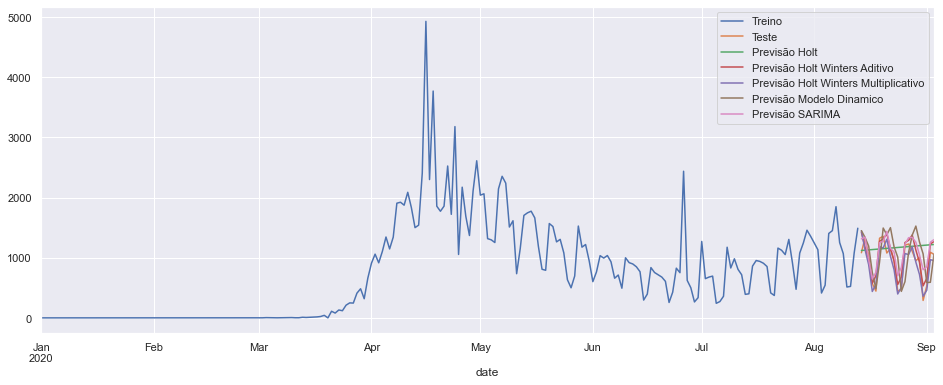

In [49]:
# plotando os resultados em um gráfico
treino['Mortes'].plot(legend=True,label='Treino')
teste['Mortes'].plot(legend=True,label='Teste',figsize=(16,6))
teste['Holt'].plot(legend=True,label='Previsão Holt');
teste['HoltWintersAditivo'].plot(legend=True,label='Previsão Holt Winters Aditivo');
teste['HoltWintersMultiplicativo'].plot(legend=True,label='Previsão Holt Winters Multiplicativo');
teste['ModeloDinamico'].plot(legend=True,label='Previsão Modelo Dinamico');
teste['SARIMA'].plot(legend=True,label='Previsão SARIMA');

In [50]:
# Calculo do erro quadratico medio na base de teste
print('EQM para Holt:', mean_squared_error(teste['Mortes'],teste['Holt']))
print('EQM para HoltWintersAditivo:', mean_squared_error(teste['Mortes'],teste['HoltWintersAditivo']))
print('EQM para HoltWintersMultiplicativo:', mean_squared_error(teste['Mortes'],teste['HoltWintersMultiplicativo']))
print('EQM para ModeloDinamico:', mean_squared_error(teste['Mortes'],teste['ModeloDinamico']))
print('EQM para SARIMA:', mean_squared_error(teste['Mortes'],teste['SARIMA']))

EQM para Holt: 164269.93388118508
EQM para HoltWintersAditivo: 29911.15875899669
EQM para HoltWintersMultiplicativo: 26394.664362585423
EQM para ModeloDinamico: 126659.5686519731
EQM para SARIMA: 53821.52339108506


In [51]:
# Calculo do erro medio absoluto na base de teste
print('Erro medio absoluto para Holt:', mean_absolute_error(teste['Mortes'],teste['Holt']))
print('Erro medio absoluto para HoltWintersAditivo:', mean_absolute_error(teste['Mortes'],teste['HoltWintersAditivo']))
print('Erro medio absoluto para HoltWintersMultiplicativo:', mean_absolute_error(teste['Mortes'],teste['HoltWintersMultiplicativo']))
print('Erro medio absoluto para ModeloDinamico:', mean_absolute_error(teste['Mortes'],teste['ModeloDinamico']))
print('Erro medio absoluto para SARIMA:', mean_absolute_error(teste['Mortes'],teste['SARIMA']))

Erro medio absoluto para Holt: 294.4637976919901
Erro medio absoluto para HoltWintersAditivo: 139.63669818694456
Erro medio absoluto para HoltWintersMultiplicativo: 140.8263480796557
Erro medio absoluto para ModeloDinamico: 282.40578733171736
Erro medio absoluto para SARIMA: 186.2642889618881


***Avaliando os resultados obtidos dos erros avaliados acima, o <span style="color:red">melhor modelo </span> ajustado para os dados é o <span style="color:red">Holt Winters com tendencia e sazonalidade multiplicativas </span>. Vale observar que ao analisar o erro absoluto do Holt Winters aditivo é ligeiramente inferior ao multiplicativo. Contudo, o EQM do multiplicativo é menor e as análises gráficas feitas nos passos anteriores corroboram que a melhor proposta para estes dados é o modelo Holt Winters com tendencia e sazonalidade multiplicativa***

In [52]:
# realizando a previsão de 14 dias a mais (período superior ao existente nos dados)
previsao_adicional = ajustadoHWMult.forecast(35)[-14:];
previsao_adicional
previsao_adicional.index = pd.date_range(start='2020-09-04', end='2020-09-17', freq='D')
previsao_adicional

2020-09-04    1069.482343
2020-09-05     837.477336
2020-09-06     652.876908
2020-09-07     324.431513
2020-09-08     414.103624
2020-09-09     874.751572
2020-09-10     859.553768
2020-09-11     967.114482
2020-09-12     757.316346
2020-09-13     590.385355
2020-09-14     293.377835
2020-09-15     374.466782
2020-09-16     791.022796
2020-09-17     777.279683
Freq: D, dtype: float64

***Abaixo, é feita a plotagem dos 14 dias adicionais que não temos na base de dados, junto às bases de treino e teste***

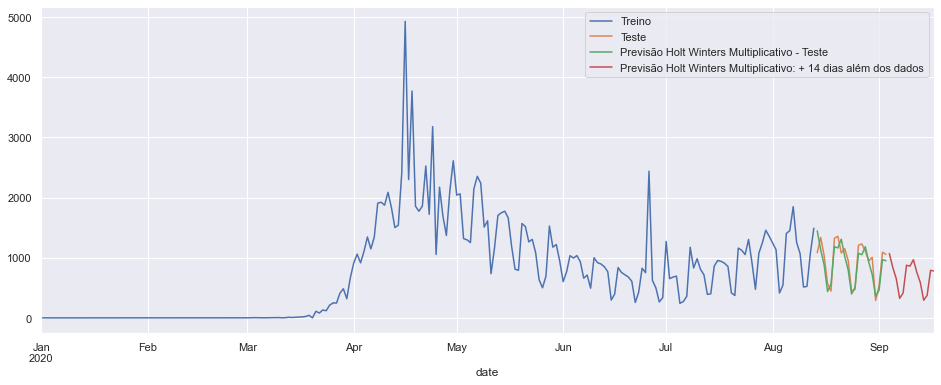

In [53]:
# plotando os resultados em um gráfico
treino['Mortes'].plot(legend=True,label='Treino')
teste['Mortes'].plot(legend=True,label='Teste',figsize=(16,6))
teste['HoltWintersMultiplicativo'].plot(legend=True,label='Previsão Holt Winters Multiplicativo - Teste');
previsao_adicional.plot(legend=True,label='Previsão Holt Winters Multiplicativo: + 14 dias além dos dados');

***Abaixo, estou iniciando alguns tratamentos para salvar uma base de dados para entrega. Nela, temos os dados de treinamento, teste e as previsões  para o método considerado campeão na base de validação e nos 14 dias adicionais solicitados***

In [54]:
treino['BASE']='Treino'
teste['BASE']='Teste'
Confirmados = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True,usecols = ['date','confirmed']).rename({'confirmed': 'Confirmados'}, axis='columns')

In [55]:
Base = treino.append(teste)
Base['Confirmados']=Confirmados

In [56]:
Base

,Mortes,BASE,Holt,HoltWintersAditivo,HoltWintersMultiplicativo,ModeloDinamico,SARIMA,Confirmados
date,,,,,,,,
2020-01-01,0,Treino,NaN,NaN,NaN,NaN,NaN,0
2020-01-02,0,Treino,NaN,NaN,NaN,NaN,NaN,0
2020-01-03,0,Treino,NaN,NaN,NaN,NaN,NaN,0
2020-01-04,0,Treino,NaN,NaN,NaN,NaN,NaN,0
2020-01-05,0,Treino,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
2020-08-30,1006,Teste,1199.752535,921.887397,721.983115,1261.162563,1047.944313,44143
2020-08-31,290,Teste,1204.715989,532.110456,358.772183,1063.531438,799.988222,35581
2020-09-01,529,Teste,1209.679442,656.884895,457.935976,587.184738,848.526738,33850


In [57]:
Adicional=pd.DataFrame(previsao_adicional)
Adicional.set_index([0])
Adicional.index.name = 'date'
Adicional.rename(columns={ Adicional.columns[0]: "HoltWintersMultiplicativo" }, inplace = True)
Adicional.head()

,HoltWintersMultiplicativo
date,
2020-09-04,1069.482343
2020-09-05,837.477336
2020-09-06,652.876908
2020-09-07,324.431513
2020-09-08,414.103624


In [58]:
Base_Exportar=Base.append(Adicional)
Base_Exportar

,Mortes,BASE,Holt,HoltWintersAditivo,HoltWintersMultiplicativo,ModeloDinamico,SARIMA,Confirmados
date,,,,,,,,
2020-01-01,0.0,Treino,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-02,0.0,Treino,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-03,0.0,Treino,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-04,0.0,Treino,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-05,0.0,Treino,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
2020-09-13,NaN,NaN,NaN,NaN,590.385355,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN,NaN,293.377835,NaN,NaN,NaN
2020-09-15,NaN,NaN,NaN,NaN,374.466782,NaN,NaN,NaN


***Dentro do arquivo exportado abaixo temos:Todos os dados de treino e teste.
Para a base de teste, temos a aplicação de todos os métodos apresentados e discutidos neste arquivo
Considerando o método de holt winters com sazonalidade e tendencia multplicativa, existem mais 14 registros que não constavam nos dados originais com novas estimativas***

In [59]:
Base_Exportar.to_csv('Base_Resultados.csv', index=True)  